In [256]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import shap


from xgboost import XGBClassifier, plot_importance, to_graphviz

from sklearn.model_selection import (
                                    train_test_split,
                                    RandomizedSearchCV,
                                    TimeSeriesSplit
                                    )

from sklearn.metrics import (
                            accuracy_score,
                            precision_recall_curve, 
                            roc_curve, 
                            RocCurveDisplay,
                            ConfusionMatrixDisplay,
                            classification_report, 
                            confusion_matrix
                            )


#import quantstats_lumi as qs

### Load Data

In [22]:
import yfinance as yf

In [39]:
dfsp500 =yf.download('SPY', period="5y",progress = False)

In [41]:
dfsp500.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2019-11-11 00:00:00+00:00,285.437622,308.350006,308.540009,307.269989,307.420013,35797300
2019-11-12 00:00:00+00:00,286.039337,309.000000,309.989990,308.149994,308.750000,46484600
2019-11-13 00:00:00+00:00,286.131927,309.100006,309.540009,307.660004,307.910004,53917700
2019-11-14 00:00:00+00:00,286.548492,309.549988,309.640015,308.089996,308.790009,51219900
2019-11-15 00:00:00+00:00,288.621979,311.790009,311.839996,310.260010,311.019989,62023600


In [47]:
print(dfsp500.columns.tolist())

[('Adj Close', 'SPY'), ('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]


In [49]:
dfsp500.index

DatetimeIndex(['2019-11-11 00:00:00+00:00', '2019-11-12 00:00:00+00:00',
               '2019-11-13 00:00:00+00:00', '2019-11-14 00:00:00+00:00',
               '2019-11-15 00:00:00+00:00', '2019-11-18 00:00:00+00:00',
               '2019-11-19 00:00:00+00:00', '2019-11-20 00:00:00+00:00',
               '2019-11-21 00:00:00+00:00', '2019-11-22 00:00:00+00:00',
               ...
               '2024-10-28 00:00:00+00:00', '2024-10-29 00:00:00+00:00',
               '2024-10-30 00:00:00+00:00', '2024-10-31 00:00:00+00:00',
               '2024-11-01 00:00:00+00:00', '2024-11-04 00:00:00+00:00',
               '2024-11-05 00:00:00+00:00', '2024-11-06 00:00:00+00:00',
               '2024-11-07 00:00:00+00:00', '2024-11-08 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=1258, freq=None)

In [52]:
dfsp500.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [54]:
print(dfsp500.columns)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


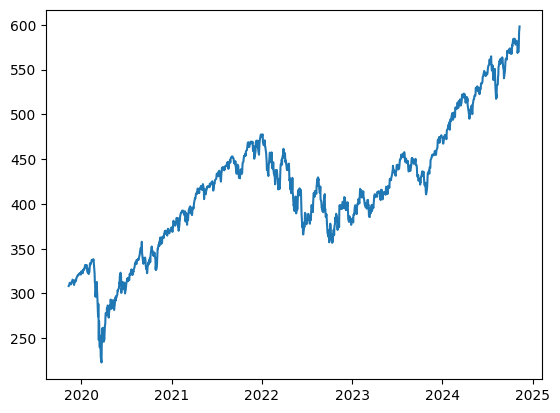

In [56]:
plt.plot(dfsp500['Close'])

In [58]:
dfsp500.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,403.722922,417.102441,419.535756,414.323803,417.011622,8.190393e+07
std,77.845552,72.743197,72.507345,72.910341,72.764238,4.141604e+07
min,208.617661,222.949997,229.679993,218.259995,228.190002,2.027000e+07
25%,358.680115,374.152504,377.669991,370.972511,373.742500,5.714205e+07
50%,401.817749,415.899994,418.025009,413.359985,415.860001,7.355830e+07
75%,441.717728,453.852501,456.179993,451.549988,454.049988,9.325712e+07
max,598.190002,598.190002,599.630005,596.164978,596.169983,3.922207e+08


In [60]:
dfsp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-11-11 00:00:00+00:00 to 2024-11-08 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1258 non-null   float64
 1   Close      1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Open       1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


In [62]:
dfsp500.isnull().sum()

Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [64]:
dfsp500.shape

(1258, 6)

### Feature Engineering

In [270]:
def feature_generate(frame):
    df = frame.copy()
    
    df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    

    for i in [7,14,28]:
        
        df['RET' + str(i)] = df['Returns'].rolling(i).mean()
        df['STD'+ str(i)] = df['Returns'].rolling(i).std()

    df['Predict'] = df['Adj Close'].shift(-1)
    df['Label'] = np.where(df['Predict'] > 1.0015 * df['Adj Close'], 1, 0)

    df.dropna(inplace=True)

    return df

In [272]:
df1 = feature_generate(dfsp500)
display(df1.shape)

(1229, 15)

In [274]:
df1

,Adj Close,Close,High,Low,Open,Volume,Returns,RET7,STD7,RET14,STD14,RET28,STD28,Predict,Label
Date,,,,,,,,,,,,,,,
2019-12-20 00:00:00+00:00,298.357422,320.730011,321.970001,319.390015,320.459991,147142100,0.004375,0.003539,0.003394,0.002404,0.004507,0.001581,0.004417,298.813232,1
2019-12-23 00:00:00+00:00,298.813232,321.220001,321.649994,321.059998,321.589996,52990000,0.001527,0.002531,0.002602,0.002994,0.003686,0.001560,0.004416,298.822571,0
2019-12-24 00:00:00+00:00,298.822571,321.230011,321.519989,320.899994,321.470001,20270000,0.000031,0.002450,0.002680,0.002556,0.003645,0.001550,0.004419,300.413208,1
2019-12-26 00:00:00+00:00,300.413208,322.940002,322.950012,321.640015,321.649994,30911200,0.005309,0.002231,0.002295,0.002807,0.003709,0.001688,0.004476,300.338867,0
2019-12-27 00:00:00+00:00,300.338867,322.859985,323.799988,322.279999,323.739990,42528800,-0.000247,0.002164,0.002369,0.002140,0.003310,0.001421,0.004355,298.682953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01 00:00:00+00:00,571.039978,571.039978,575.549988,570.619995,571.320007,45667500,0.004212,-0.001728,0.008316,-0.001642,0.006678,-0.000016,0.006515,569.809998,0
2024-11-04 00:00:00+00:00,569.809998,569.809998,572.500000,567.890015,571.179993,38217000,-0.002156,-0.002345,0.008137,-0.001239,0.006444,-0.000014,0.006515,576.700012,1
2024-11-05 00:00:00+00:00,576.700012,576.700012,576.739990,570.520020,570.739990,39478300,0.012019,-0.000578,0.009813,-0.000690,0.007234,0.000274,0.006866,591.039978,1


In [276]:
dff =  df1.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [278]:
dff

,Returns,RET7,STD7,RET14,STD14,RET28,STD28,Predict,Label
Date,,,,,,,,,
2019-12-20 00:00:00+00:00,0.004375,0.003539,0.003394,0.002404,0.004507,0.001581,0.004417,298.813232,1
2019-12-23 00:00:00+00:00,0.001527,0.002531,0.002602,0.002994,0.003686,0.001560,0.004416,298.822571,0
2019-12-24 00:00:00+00:00,0.000031,0.002450,0.002680,0.002556,0.003645,0.001550,0.004419,300.413208,1
2019-12-26 00:00:00+00:00,0.005309,0.002231,0.002295,0.002807,0.003709,0.001688,0.004476,300.338867,0
2019-12-27 00:00:00+00:00,-0.000247,0.002164,0.002369,0.002140,0.003310,0.001421,0.004355,298.682953,0
...,...,...,...,...,...,...,...,...,...
2024-11-01 00:00:00+00:00,0.004212,-0.001728,0.008316,-0.001642,0.006678,-0.000016,0.006515,569.809998,0
2024-11-04 00:00:00+00:00,-0.002156,-0.002345,0.008137,-0.001239,0.006444,-0.000014,0.006515,576.700012,1
2024-11-05 00:00:00+00:00,0.012019,-0.000578,0.009813,-0.000690,0.007234,0.000274,0.006866,591.039978,1


In [280]:
dfx =  df1.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Predict', 'Label'], axis=1)

In [282]:
dfx

,Returns,RET7,STD7,RET14,STD14,RET28,STD28
Date,,,,,,,
2019-12-20 00:00:00+00:00,0.004375,0.003539,0.003394,0.002404,0.004507,0.001581,0.004417
2019-12-23 00:00:00+00:00,0.001527,0.002531,0.002602,0.002994,0.003686,0.001560,0.004416
2019-12-24 00:00:00+00:00,0.000031,0.002450,0.002680,0.002556,0.003645,0.001550,0.004419
2019-12-26 00:00:00+00:00,0.005309,0.002231,0.002295,0.002807,0.003709,0.001688,0.004476
2019-12-27 00:00:00+00:00,-0.000247,0.002164,0.002369,0.002140,0.003310,0.001421,0.004355
...,...,...,...,...,...,...,...
2024-11-01 00:00:00+00:00,0.004212,-0.001728,0.008316,-0.001642,0.006678,-0.000016,0.006515
2024-11-04 00:00:00+00:00,-0.002156,-0.002345,0.008137,-0.001239,0.006444,-0.000014,0.006515
2024-11-05 00:00:00+00:00,0.012019,-0.000578,0.009813,-0.000690,0.007234,0.000274,0.006866


In [284]:
y = dff['Label']

In [286]:
y

Date
2019-12-20 00:00:00+00:00    1
2019-12-23 00:00:00+00:00    0
2019-12-24 00:00:00+00:00    1
2019-12-26 00:00:00+00:00    0
2019-12-27 00:00:00+00:00    0
                            ..
2024-11-01 00:00:00+00:00    0
2024-11-04 00:00:00+00:00    1
2024-11-05 00:00:00+00:00    1
2024-11-06 00:00:00+00:00    1
2024-11-07 00:00:00+00:00    1
Name: Label, Length: 1229, dtype: int64

In [288]:
y.value_counts()

Label
0    650
1    579
Name: count, dtype: int64

**class balance method**

In [125]:
dff['Label02']= np.where(dff['Returns'].shift(-1) > dff['Returns'].median(),1,0)

In [127]:
y02 = dff['Label02']

In [129]:
y02.value_counts()

Label02
0    616
1    613
Name: count, dtype: int64

In [290]:
X = dfx

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Base Model

In [295]:
basemodel = XGBClassifier(verbosity = 0, silent=True, random_state=42)

basemodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [297]:
y_pred = basemodel.predict(X_test)

In [299]:
acc_train = accuracy_score(y_train, basemodel.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 1.0, Test Accuracy: 0.4634


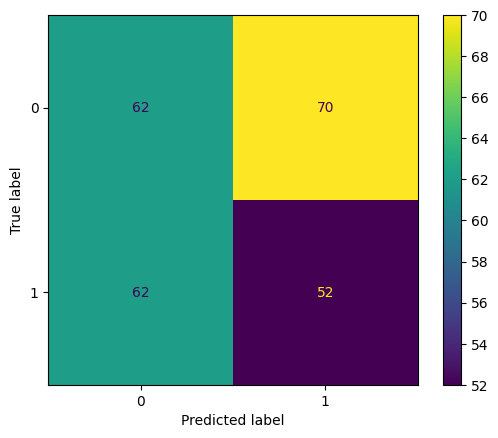

In [301]:
disp = ConfusionMatrixDisplay.from_estimator(
        basemodel,
        X_test,
        y_test,
       )

plt.show()

<Axes: >

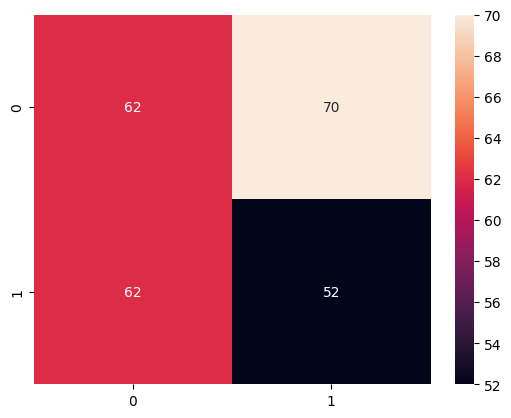

In [303]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [305]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[62 70]
 [62 52]]


In [307]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.47      0.48       132
           1       0.43      0.46      0.44       114

    accuracy                           0.46       246
   macro avg       0.46      0.46      0.46       246
weighted avg       0.47      0.46      0.46       246



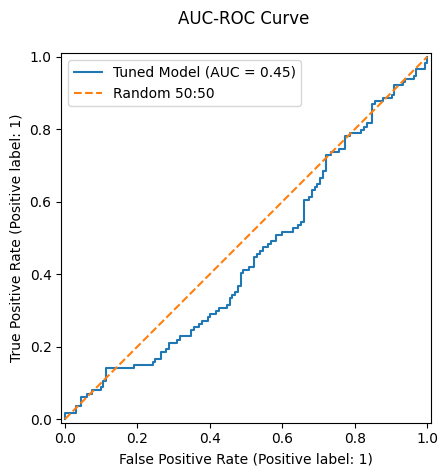

In [309]:
disp = RocCurveDisplay.from_estimator(
            basemodel, 
            X_test, 
            y_test,
            name='Tuned Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

### Hyper-parameter Tuning

In [175]:
basemodel.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'silent': True}

In [311]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [313]:
param_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20],
              'max_depth': [3, 6, 9, 12, 15],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
              'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]}


rs = RandomizedSearchCV(
                        basemodel,
                        param_grid, 
                        n_iter=100, 
                        scoring='f1', 
                        cv=tscv, 
                        verbose=2
                        )

rs.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=15, min_child_weight=7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=15, min_child_weight=7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=15, min_child_weight=7; total time=   0.0s
[CV] END colsample_bytree=0.7,

RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=N...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [3, 6, 9, 12, 15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1', verbose=2)

In [315]:
tunedmodel = rs.best_estimator_

In [317]:
rs.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [319]:
y_pred = tunedmodel.predict(X_test)

In [321]:
acc_train = accuracy_score(y_train, tunedmodel.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.6938 
 Test Accuracy 		: 0.4878


<Axes: >

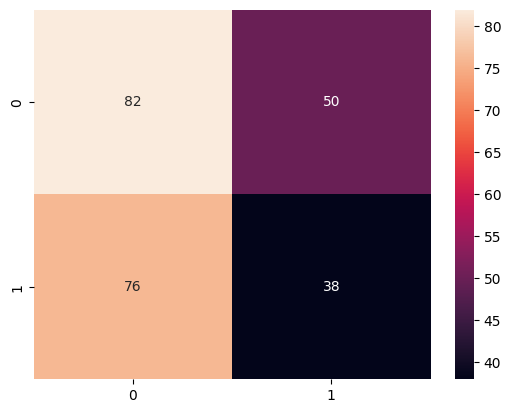

In [323]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [325]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[82 50]
 [76 38]]


In [327]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.62      0.57       132
           1       0.43      0.33      0.38       114

    accuracy                           0.49       246
   macro avg       0.48      0.48      0.47       246
weighted avg       0.48      0.49      0.48       246



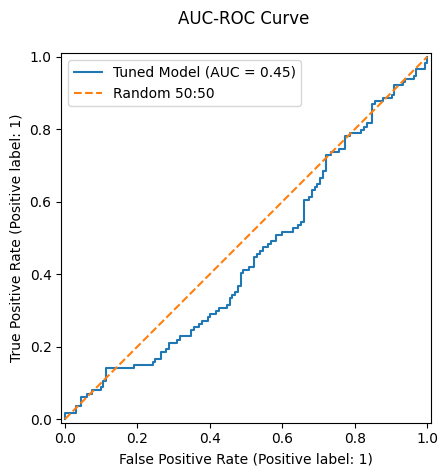

In [329]:
disp = RocCurveDisplay.from_estimator(
            basemodel, 
            X_test, 
            y_test,
            name='Tuned Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

### Feature Importance

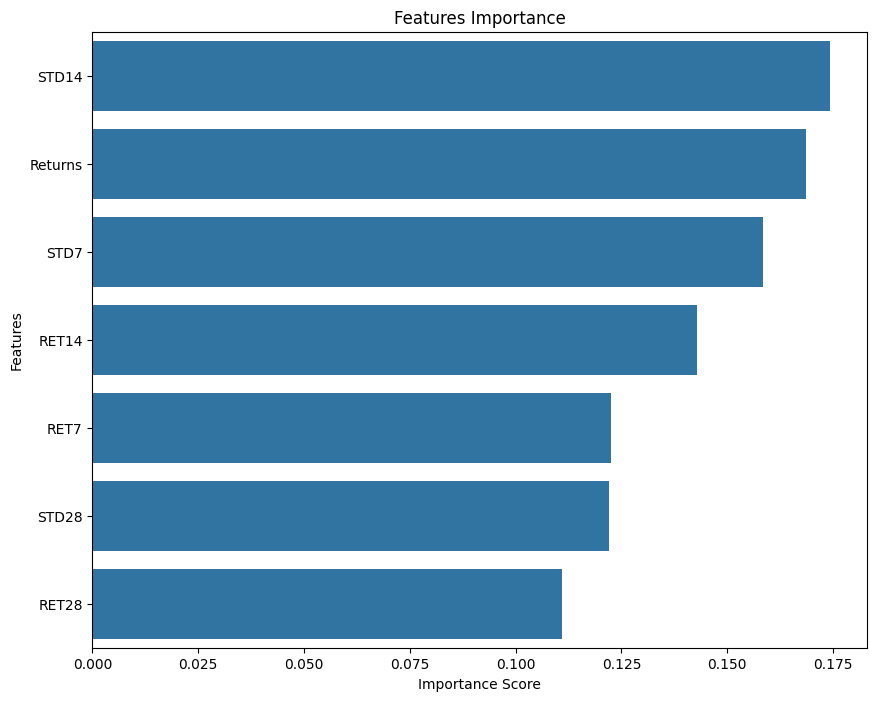

In [331]:
fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': tunedmodel.feature_importances_,'Features': X.columns}).sort_values(by='Importance Score', ascending=False)

sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');

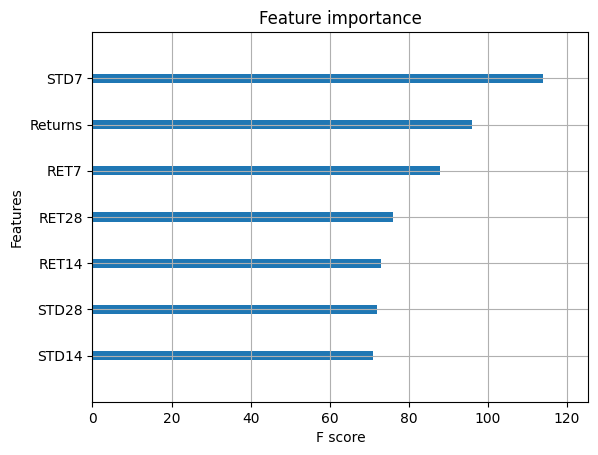

In [333]:
plot_importance(tunedmodel, importance_type='weight', show_values=False);

In [335]:
explainer = shap.TreeExplainer(tunedmodel)
shap_values = explainer.shap_values(X_test)

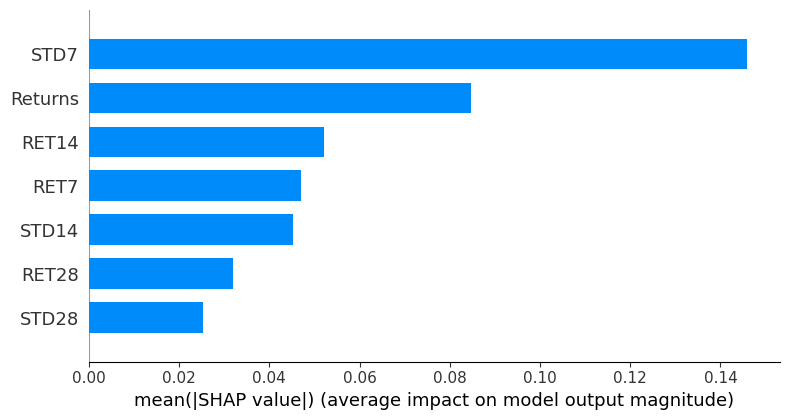

In [337]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

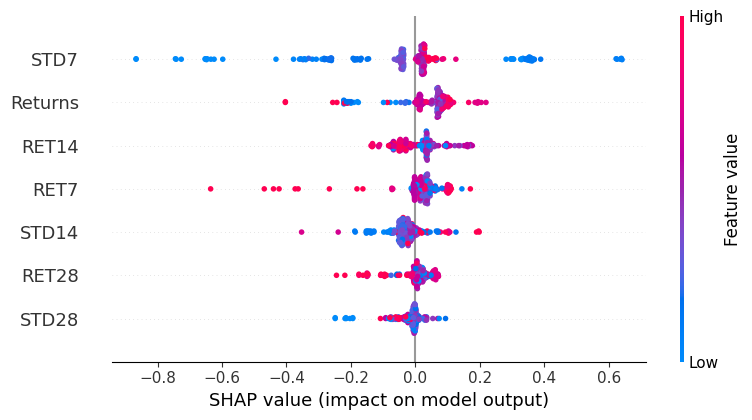

In [339]:
shap.summary_plot(shap_values, X_test)